In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

from flight.federation.topologies import Node
from flight.federation.topologies.node import WorkerState
from flight.learning.modules.torch import FlightModule, TorchDataModule
from flight.learning.trainers.torch import TorchTrainer
from flight.learning.types import LocalStepOutput
from flight.strategies.base import DefaultTrainerStrategy

In [2]:
class MyCifarModule(FlightModule):
    """Neural network for Flight to learn on Cifar-10."""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_nb) -> LocalStepOutput:
        inputs, targets = batch
        preds = self(inputs)
        loss = self.criterion(preds, targets)
        return loss

    def validation_step(self, batch, batch_nb) -> LocalStepOutput:
        return self.training_step(batch, batch_nb)

    def configure_optimizers(self) -> torch.optim.Optimizer:
        return torch.optim.SGD(self.parameters(), lr=0.001)

In [3]:
class CifarDataModule(TorchDataModule):
    """Fligth data module for loading the Cifar-10 data."""
    def __init__(self, root: Path | str, batch_size: int = 128):
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self._train_data = CIFAR10(
            root=root, train=True, download=False, transform=transform
        )
        self._test_data = CIFAR10(
            root=root, train=False, download=False, transform=transform
        )
        self.batch_size = batch_size

    def train_data(self, node: Node | None = None) -> DataLoader:
        subset = Subset(
            self._train_data,
            indices=list(range(0, 45_000)),
        )
        return DataLoader(subset, self.batch_size)

    def valid_data(self, node: Node | None = None) -> DataLoader:
        subset = Subset(
            self._train_data,
            indices=list(range(45_000, len(self._train_data))),
        )
        return DataLoader(subset, self.batch_size)

    def test_data(self, node: Node | None = None) -> DataLoader:
        return DataLoader(self._test_data, self.batch_size)

In [4]:
module = MyCifarModule()
module

MyCifarModule(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
)

In [5]:
data = CifarDataModule("~/Research/Data/Torch-Data/")
data

In [6]:
trainer = TorchTrainer(
    Node(idx=0, kind="worker"),
    DefaultTrainerStrategy(),
    max_epochs=30,
)
results = trainer.fit(
    WorkerState(0, None, None),
    module,
    data,
)

df = pd.DataFrame.from_records(results)
df.head()

TorchTrainer(NodeID=0) | epoch=29: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11760/11760 [06:23<00:00, 30.67it/s]


,epoch,train/loss,train/batch_idx,train/step,valid/loss,valid/batch_idx,valid/step
0,0,2.312771,0.0,0.0,NaN,NaN,NaN
1,0,2.298470,1.0,1.0,NaN,NaN,NaN
2,0,2.300480,2.0,2.0,NaN,NaN,NaN
3,0,2.303983,3.0,3.0,NaN,NaN,NaN
4,0,2.305635,4.0,4.0,NaN,NaN,NaN


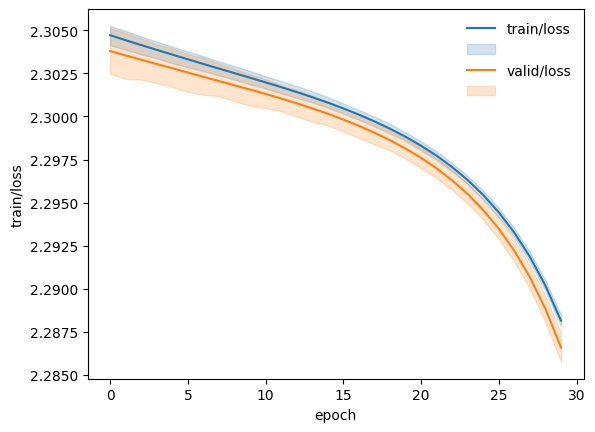

In [17]:
sns.lineplot(df, x="epoch", y="train/loss")
sns.lineplot(df, x="epoch", y="valid/loss")
plt.legend(["train/loss", "", "valid/loss", ""], frameon=False)
plt.show()